In [67]:
import tensorflow as tf
import keras
from keras import layers, losses, optimizers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from keras.datasets import cifar10

1. Preparation and Inspection of the Data

In [68]:
def prep_cifar(train_data, test_data, batch_size):
    def preprocessing_func(img, label):
        img = tf.cast(img, tf.float32)
        img = (img / 128) - 1  # Normalized
        label = tf.one_hot(label, depth=10)
        return img, label

    train_data = train_data.map(preprocessing_func).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_data = test_data.map(preprocessing_func).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return train_data, test_data

'''
def prep_cifar(train_data, test_data, batch_size, shuffle_buffer_size):
    def preprocessing_func(img, label):
        img = tf.cast(img, tf.float32)
        img = (img/128) - 1 #// normalized
        label = tf.cast(label, tf.int32) # Cast lables
        label = tf.one_hot(label, depth=10)
        return img, label

    train_data = train_data.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(2)
    test_data = test_data.map(preprocessing_func)
    test_data = test_data.batch(1)
    return train_data, test_data
'''


def get_familiar_with_data(dataset, name):
    for images, labels in dataset.take(1):
        print(f"{name} batch size:", images.shape[0])
        print("Each image size:", images.shape[1:])
        sample_labels = labels.numpy()
        print(f"Sample labels from {name} set:", sample_labels[:5] if sample_labels.ndim > 0 else sample_labels)

def visualize_data(dataset, num_images=9):
    class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                   'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            img = ((images[i].numpy() + 1) * 128).astype("uint8")  # Denormalize
            plt.imshow(img)
            plt.title(class_names[np.argmax(labels[i])])
            plt.axis("off")

    plt.show()
'''
def visualize_data(dataset):
    class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
                   'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

    for images, labels in dataset.take(1):
        plt.figure(figsize=(12, 12))
        num_images = min(images.shape[0], 25)

        for i in range(num_images):
            ax = plt.subplot(5, 5, i + 1)

            img = images[i].numpy() / 255.0  # Scale pixel values to [0, 1]

            plt.imshow(img)
            plt.axis("off")

            # Handling both scalar and one-hot encoded labels
            label = labels[i].numpy()
            if label.ndim > 0:
                label_index = np.argmax(label)
            else:
                label_index = label
            plt.title(class_names[label_index])

        plt.show()
'''

'\ndef visualize_data(dataset):\n    class_names = [\'Airplane\', \'Automobile\', \'Bird\', \'Cat\', \'Deer\',\n                   \'Dog\', \'Frog\', \'Horse\', \'Ship\', \'Truck\']\n\n    for images, labels in dataset.take(1):\n        plt.figure(figsize=(12, 12))\n        num_images = min(images.shape[0], 25)\n\n        for i in range(num_images):\n            ax = plt.subplot(5, 5, i + 1)\n            \n            img = images[i].numpy() / 255.0  # Scale pixel values to [0, 1]\n            \n            plt.imshow(img)\n            plt.axis("off")\n\n            # Handling both scalar and one-hot encoded labels\n            label = labels[i].numpy()\n            if label.ndim > 0:\n                label_index = np.argmax(label)\n            else:\n                label_index = label\n            plt.title(class_names[label_index])\n\n        plt.show()\n'

In [69]:
# Load CIFAR10 dataset
train_data, test_data = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

cifar batch size: 64
Each image size: (32, 32, 3)
Sample labels from cifar set: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


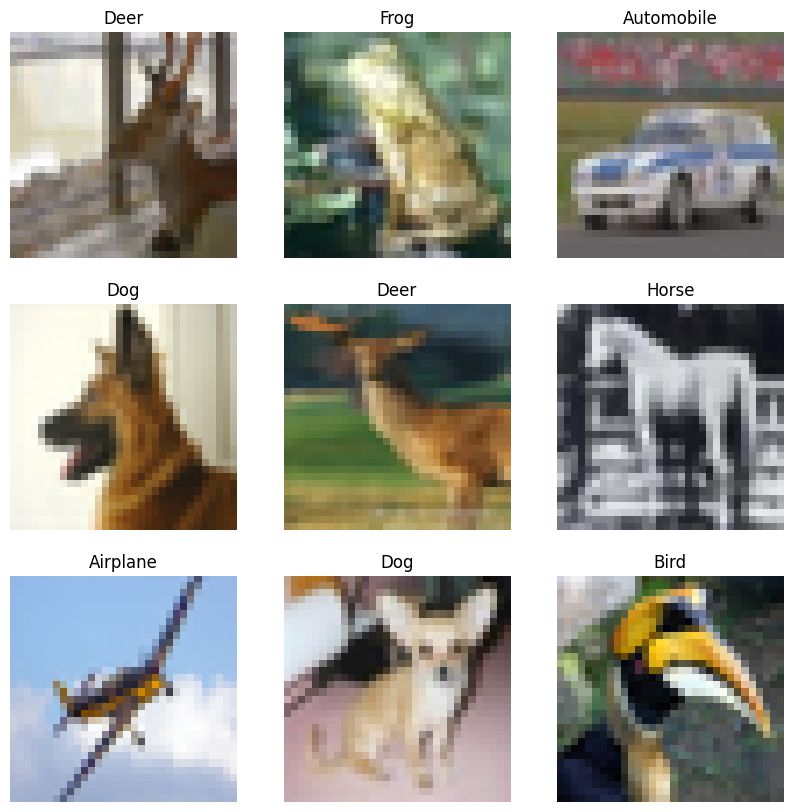

In [70]:
# Preprocess the data
batch_size = 64
shuffle_buffer_size = 10000

# Train the data
#train_data, test_data = prep_cifar(train_data, test_data, batch_size, shuffle_buffer_size)
train_data, test_data = prep_cifar(train_data, test_data, batch_size)

# Get familiar with the data
get_familiar_with_data(train_data, 'cifar')

# Visualize the data
visualize_data(train_data)





2. The CNN Model

In [73]:

class CNN():
    def __init__(self, input_size=(32, 32, 3), num_filters=[32, 64, 128], kernel_size=[(3,3), (3,3), (3,3)], strides=[(1,1), (1,1), (1,1)], conv_activation='relu', cnn_pool_type="max_pool",
                 padding="valid", use_bias=False, dense_activation='relu', dense_sizes=[256], num_classes=10, flatten_type="global_max", name="CNN_model"):

        self.input_size = input_size
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.conv_activation = conv_activation
        self.cnn_pool_type = cnn_pool_type
        self.padding = padding
        self.use_bias = use_bias
        self.dense_activation = dense_activation
        self.dense_sizes = dense_sizes
        self.num_classes = num_classes
        self.flatten_type = flatten_type
        self.name = name
        self.last_performance = {
            'train_loss_results': [],
            'train_accuracy_results': [],
            'test_loss': -1,
            'test_accuracy': -1,
        }

        self.model = None
        self.create_cnn()



    def create_cnn(self):
        inputs = layers.Input(shape=(self.input_size), dtype=tf.float32)
        x = inputs

        # Create CNN part with pooling layers
        for i, num_filter in enumerate(self.num_filters):
            x = layers.Conv2D(num_filter, self.kernel_size[i], self.strides[i], self.padding, activation=self.conv_activation, use_bias=self.use_bias)(x)
            x = layers.BatchNormalization()(x)
            if self.cnn_pool_type == "max_pool":
                x = layers.MaxPool2D()(x)
            else:
                x = layers.AveragePooling2D()(x)
            #x = layers.Dropout(0.2)(x)

        # Flatten the output of the CNN part for it to fit into the MLP part
        if self.flatten_type == "global_max":
            x = layers.GlobalMaxPool2D()(x)
        else:
            x = layers.GlobalAveragePooling2D()(x)

        # Create the MLP part
        for i, dense_size in enumerate(self.dense_sizes):
            x = layers.Dense(dense_size, activation=self.dense_activation)(x)

        # Create the output part
        y = layers.Dense(units=self.num_classes, activation='softmax')(x)

        self.model = keras.Model(inputs=inputs, outputs=y, name=self.name)
        self.model.summary()




    def train(self, train_data, test_data, epochs=15, learning_rate=0.01, optimizer='adam'):
        # Setup the optimizer
        if optimizer == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        else:
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

        loss_f = tf.keras.losses.CategoricalCrossentropy()

        self.last_performance['test_loss_results'] = []
        self.last_performance['test_accuracy_results'] = []

        # Training loop
        for epoch in range(epochs):
            epoch_loss_avg = tf.keras.metrics.Mean()
            epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
            for image, label in train_data:
                with tf.GradientTape() as tape:
                    pred = self.model(image)
                    loss = loss_f(label, pred)

                gradients = tape.gradient(loss, self.model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

                epoch_loss_avg.update_state(loss)
                epoch_accuracy.update_state(label, pred)

            self.last_performance['train_loss_results'].append(epoch_loss_avg.result())
            self.last_performance['train_accuracy_results'].append(epoch_accuracy.result())
            print(f"Epoch {epoch+1}: Loss: {epoch_loss_avg.result()}, Accuracy: {epoch_accuracy.result()}")

            test_loss, test_accuracy = self.evaluate(test_data)
            self.last_performance['test_loss_results'].append(test_loss)
            self.last_performance['test_accuracy_results'].append(test_accuracy)

            print(f"Epoch {epoch+1}: Loss: {epoch_loss_avg.result()}, Accuracy: {epoch_accuracy.result()}")
            print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

        self.last_performance['test_loss'], self.last_performance['test_accuracy'] = self.evaluate(test_data)
        print(f"Test Loss: {self.last_performance['test_loss']}, Test Accuracy: {self.last_performance['test_accuracy']}")




    def evaluate(self, test_data):
        loss_f = tf.keras.losses.CategoricalCrossentropy()
        loss_list = []
        correct_predictions = 0
        total_samples = 0

        for image, label in test_data:
            pred = self.model(image)
            loss = loss_f(label, pred)
            loss_list.append(loss)

            # Fix: Compare the arrays element-wise
            correct_predictions += np.sum(np.argmax(label, axis=-1) == np.argmax(pred, axis=-1))
            total_samples += label.shape[0]

        # Calculate average loss and accuracy
        average_loss = np.mean(loss_list)
        accuracy = correct_predictions / total_samples
        return average_loss, accuracy

    def visualize_performance(self):
        epochs_range = range(1, len(self.last_performance['train_loss_results']) + 1)

        plt.figure(figsize=(14, 5))

        # Plot training and testing loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, self.last_performance['train_loss_results'], label='Training Loss')
        plt.plot(epochs_range, self.last_performance['test_loss_results'], label='Testing Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Testing Loss')
        plt.legend()

        # Plot training and testing accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, self.last_performance['train_accuracy_results'], label='Training Accuracy')
        plt.plot(epochs_range, self.last_performance['test_accuracy_results'], label='Testing Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Testing Accuracy')
        plt.legend()

        plt.show()



        # Print and visualize test accuracy
        #print(f"Test accuracy: {self.last_performance['test_accuracy']}")
        #print(f"Test loss: {self.last_performance['test_loss']}")






Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 30, 30, 32)        864       
                                                                 
 batch_normalization_30 (Ba  (None, 30, 30, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_31 (Conv2D)          (None, 13, 13, 64)        18432     
                                                                 
 batch_normalization_31 (Ba  (None, 13, 13, 64)        25

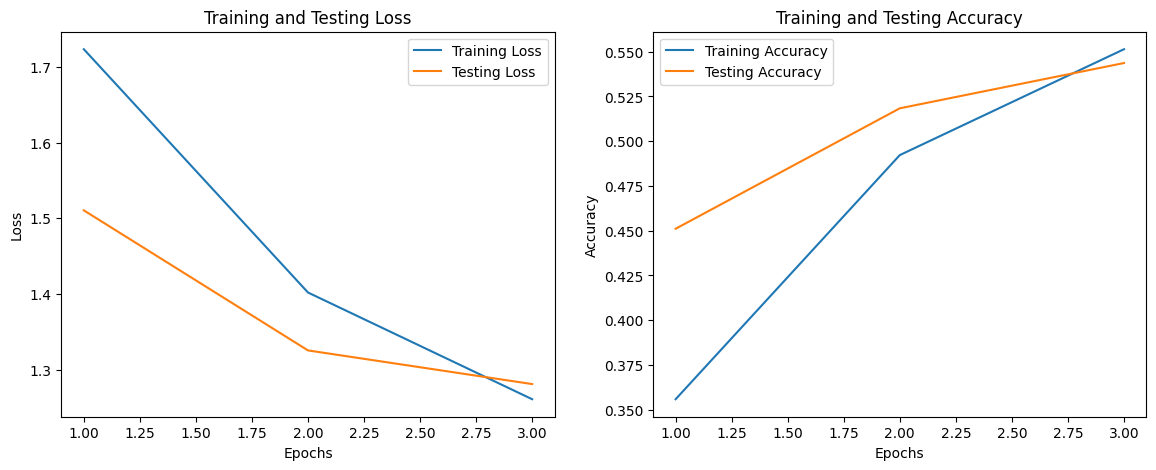

In [74]:
# Default Set of Hyperparameters for Testing Purposes
cnn_model = CNN()
cnn_model.train(train_data, test_data, epochs=3)
cnn_model.visualize_performance()


3. Hyperparameter Tuning

Model: "Set_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_33 (Conv2D)          (None, 30, 30, 32)        864       
                                                                 
 batch_normalization_33 (Ba  (None, 30, 30, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 13, 13, 64)        18432     
                                                                 
 batch_normalization_34 (Ba  (None, 13, 13, 64)        256   

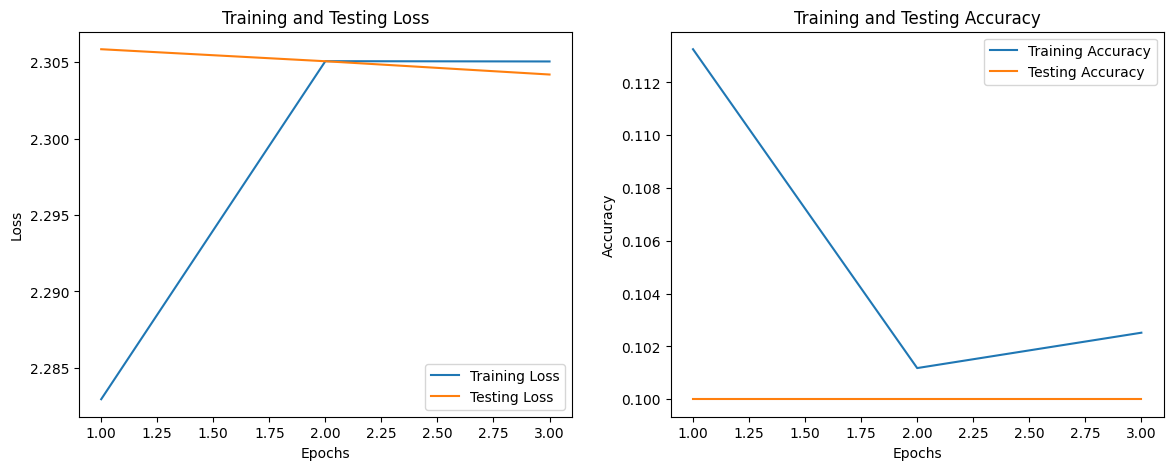

In [75]:
# Set 1:
set1_model = CNN(
    num_filters=[32, 64, 128],
    kernel_size=[(3,3), (3,3), (3,3)],
    strides=[(1,1), (1,1), (1,1)],
    conv_activation='elu',
    cnn_pool_type='max_pool',
    padding='valid',
    use_bias=False,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='global_max',
    name="Set_1",
)
train_data, test_data = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)

# Preprocess the data for set 1 with specific batch size and shuffle buffer size
batch_size_set1 = 32
train_data_set1, test_data_set1 = prep_cifar(train_data, test_data, batch_size_set1)

# Train set 1 model with the specified hyperparameters
set1_model.train(train_data_set1, test_data_set1, epochs=3)

#set1_model.train(train_data_set1, test_data_set1, epochs=15, learning_rate=0.0001, optimizer='rmsprop')
set1_model.visualize_performance()


Discussion of result:
Slow learning due to low learning rate -> would need more epochs of training for a better performance

Model: "Set_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 16, 16, 32)        384       
                                                                 
 batch_normalization_48 (Ba  (None, 16, 16, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 8, 8, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 6, 6, 64)          18432     
                                                                 
 batch_normalization_49 (Ba  (None, 6, 6, 64)          256   

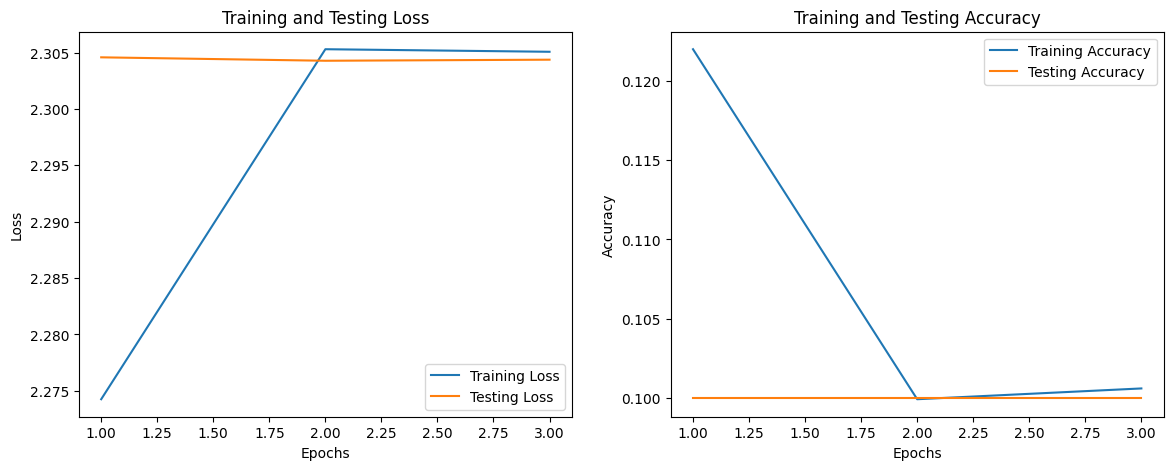

In [80]:
# Set 2:
set2_model = CNN(
    num_filters=[32, 64, 128],
    kernel_size=[(2,2), (3,3), (2,2)],
    strides=[(2,2), (1,1), (1,1)],
    conv_activation='elu',
    cnn_pool_type='max_pool',
    padding='valid',
    use_bias=False,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='global_max',
    name="Set_2",
)
train_data, test_data = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)


batch_size_set1 = 32
train_data_set2, test_data_set2 = prep_cifar(train_data, test_data, batch_size_set1)

# Train set 1 model with the specified hyperparameters
set2_model.train(train_data_set2, test_data_set2, epochs=3)

#set1_model.train(train_data_set1, test_data_set1, epochs=15, learning_rate=0.0001, optimizer='rmsprop')
set2_model.visualize_performance()


Model: "Set_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_51 (Conv2D)          (None, 16, 16, 64)        832       
                                                                 
 batch_normalization_51 (Ba  (None, 16, 16, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_51 (MaxPooli  (None, 8, 8, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_52 (Conv2D)          (None, 6, 6, 128)         73856     
                                                                 
 batch_normalization_52 (Ba  (None, 6, 6, 128)         512   

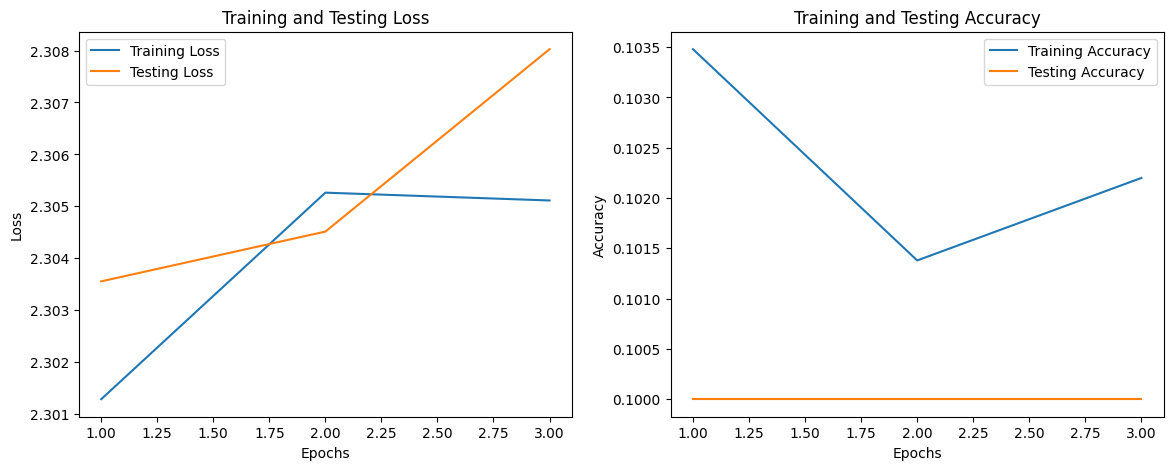

In [81]:
# Set 3:
set3_model = CNN(
    num_filters=[64, 128, 128],
    kernel_size=[(2,2), (3,3), (2,2)],
    strides=[(2,2), (1,1), (1,1)],
    conv_activation='relu',
    cnn_pool_type='max_pool',
    padding='valid',
    use_bias=True,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='global_max',
    name="Set_3",
)

batch_size_set1 = 32
train_data_set3, test_data_set3 = prep_cifar(train_data, test_data, batch_size_set1)

# Train set 1 model with the specified hyperparameters
set3_model.train(train_data_set3, test_data_set3, epochs=3)

#set1_model.train(train_data_set1, test_data_set1, epochs=15, learning_rate=0.0001, optimizer='rmsprop')
set3_model.visualize_performance()

Model: "Set_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_54 (Conv2D)          (None, 16, 16, 64)        832       
                                                                 
 batch_normalization_54 (Ba  (None, 16, 16, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_54 (MaxPooli  (None, 8, 8, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 6, 6, 128)         73856     
                                                                 
 batch_normalization_55 (Ba  (None, 6, 6, 128)         512   

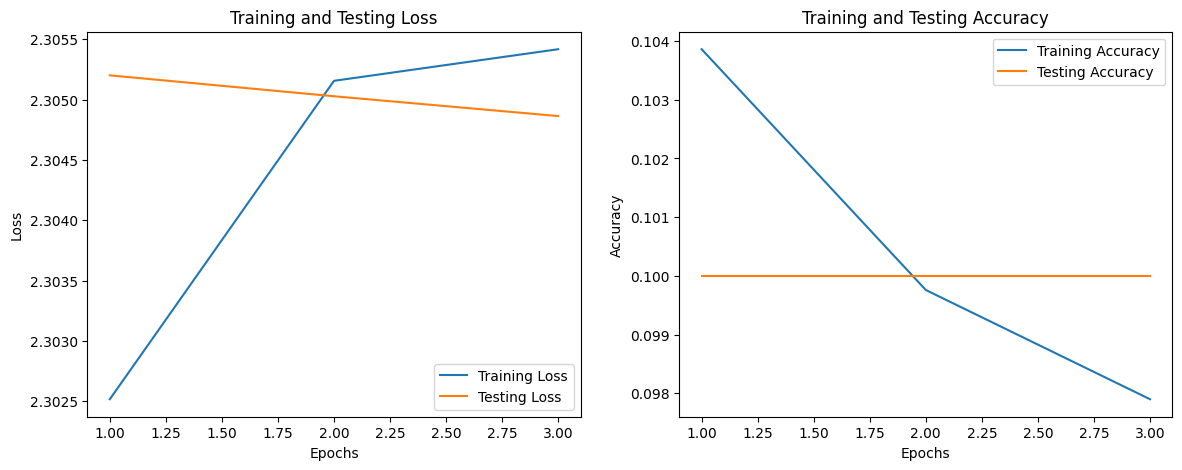

In [82]:
# Set 4:
set4_model = CNN(
    num_filters=[64, 128, 128],
    kernel_size=[(2,2), (3,3), (2,2)],
    strides=[(2,2), (1,1), (1,1)],
    conv_activation='relu',
    cnn_pool_type='max_pool',
    padding='valid',
    use_bias=True,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='global_max',
    name="Set_4",
)

batch_size_set1 = 32
train_data_set4, test_data_set4 = prep_cifar(train_data, test_data, batch_size_set1)

# Train set 1 model with the specified hyperparameters
set4_model.train(train_data_set2, test_data_set2, epochs=3)

#set1_model.train(train_data_set1, test_data_set1, epochs=15, learning_rate=0.0001, optimizer='rmsprop')
set4_model.visualize_performance()

Model: "Set_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_57 (Conv2D)          (None, 15, 15, 64)        1792      
                                                                 
 batch_normalization_57 (Ba  (None, 15, 15, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 7, 7, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_58 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 batch_normalization_58 (Ba  (None, 3, 3, 64)          256   

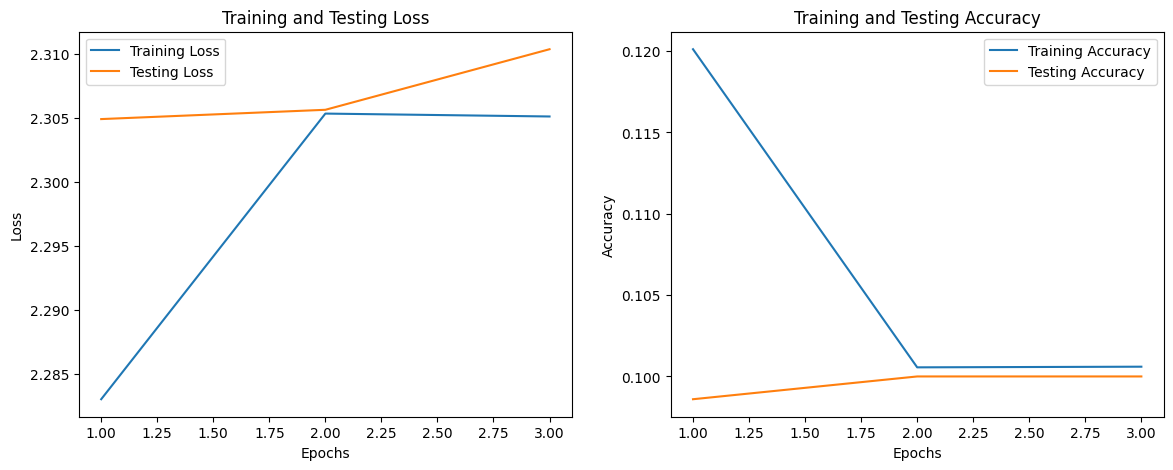

In [83]:
# Set 5:
set5_model = CNN(
    num_filters=[64, 64],
    kernel_size=[(3,3), (3,3)],
    strides=[(2,2), (2,2)],
    conv_activation='relu',
    cnn_pool_type='max_pool',
    padding='valid',
    use_bias=True,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='global_max',
    name="Set_5",
)
train_data5, test_data5 = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)


batch_size_set1 = 32
train_data_set5, test_data_set5 = prep_cifar(train_data, test_data, batch_size_set1)

# Train set 1 model with the specified hyperparameters
set5_model.train(train_data_set5, test_data_set5, epochs=3)

#set1_model.train(train_data_set1, test_data_set1, epochs=15, learning_rate=0.0001, optimizer='rmsprop')
set5_model.visualize_performance()

Model: "Set_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_59 (Conv2D)          (None, 15, 15, 64)        1792      
                                                                 
 batch_normalization_59 (Ba  (None, 15, 15, 64)        256       
 tchNormalization)                                               
                                                                 
 average_pooling2d (Average  (None, 7, 7, 64)          0         
 Pooling2D)                                                      
                                                                 
 conv2d_60 (Conv2D)          (None, 3, 3, 128)         73856     
                                                                 
 batch_normalization_60 (Ba  (None, 3, 3, 128)         512   

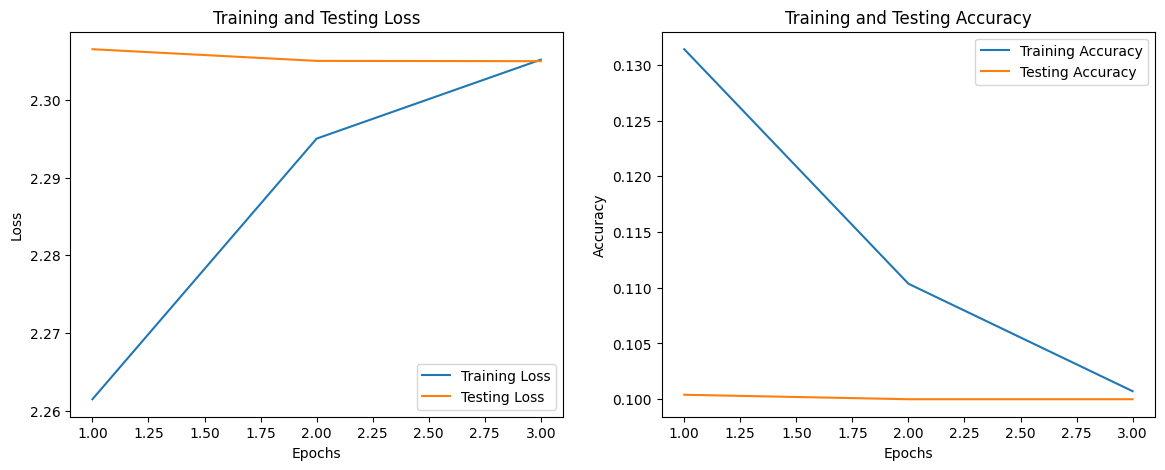

In [84]:
# Set 6:
set6_model = CNN(
    num_filters=[64, 128],
    kernel_size=[(3,3), (3,3)],
    strides=[(2,2), (2,2)],
    conv_activation='relu',
    cnn_pool_type='av_pool',
    padding='valid',
    use_bias=True,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='av_max',
    name="Set_6",
)
train_data6, test_data6 = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)


batch_size_set6 = 32
train_data_set6, test_data_set6 = prep_cifar(train_data, test_data, batch_size_set1)

# Train set 1 model with the specified hyperparameters
set6_model.train(train_data_set6, test_data_set6, epochs=3)

#set1_model.train(train_data_set1, test_data_set1, epochs=15, learning_rate=0.0001, optimizer='rmsprop')
set6_model.visualize_performance()

Model: "Set_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_61 (Conv2D)          (None, 30, 30, 64)        1728      
                                                                 
 batch_normalization_61 (Ba  (None, 30, 30, 64)        256       
 tchNormalization)                                               
                                                                 
 average_pooling2d_2 (Avera  (None, 15, 15, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_62 (Conv2D)          (None, 13, 13, 128)       73728     
                                                                 
 batch_normalization_62 (Ba  (None, 13, 13, 128)       512   

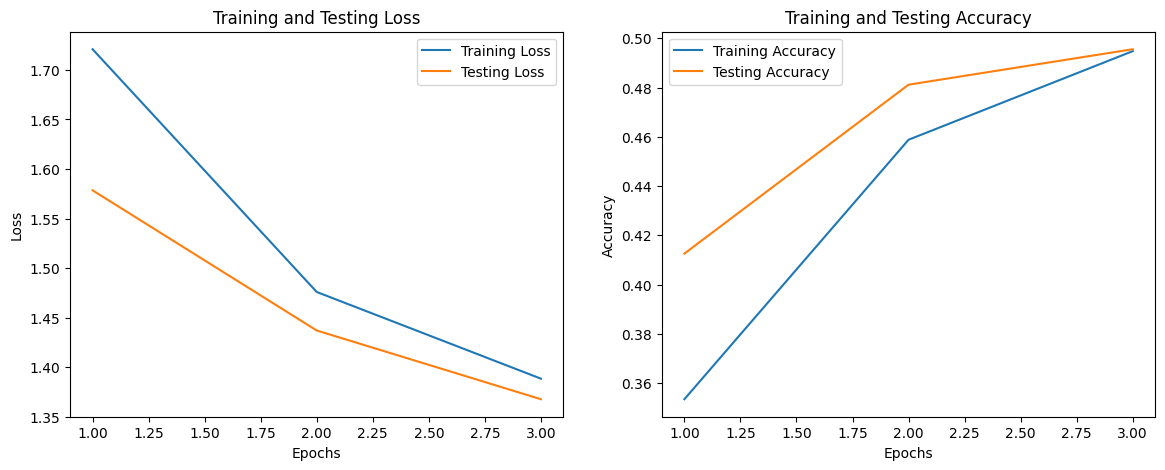

In [85]:
# Set 7:
set7_model = CNN(
    num_filters=[64, 128],
    kernel_size=[(3,3), (3,3)],
    strides=[(1,1), (1,1)],
    conv_activation='relu',
    cnn_pool_type='av_pool',
    padding='valid',
    use_bias=False,
    dense_activation='tanh',
    dense_sizes=[128],
    flatten_type='av_max',
    name="Set_7",
)

train_data7, test_data7 = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)


batch_size_set7 = 32
train_data_set7, test_data_set7 = prep_cifar(train_data, test_data, batch_size_set7)

# Train set 1 model with the specified hyperparameters
set7_model.train(train_data_set7, test_data_set7, epochs=3)

#set1_model.train(train_data_set1, test_data_set1, epochs=15, learning_rate=0.0001, optimizer='rmsprop')
set7_model.visualize_performance()

Model: "Set_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_63 (Conv2D)          (None, 31, 31, 32)        384       
                                                                 
 batch_normalization_63 (Ba  (None, 31, 31, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_59 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_64 (Conv2D)          (None, 14, 14, 64)        8192      
                                                                 
 batch_normalization_64 (Ba  (None, 14, 14, 64)        256   

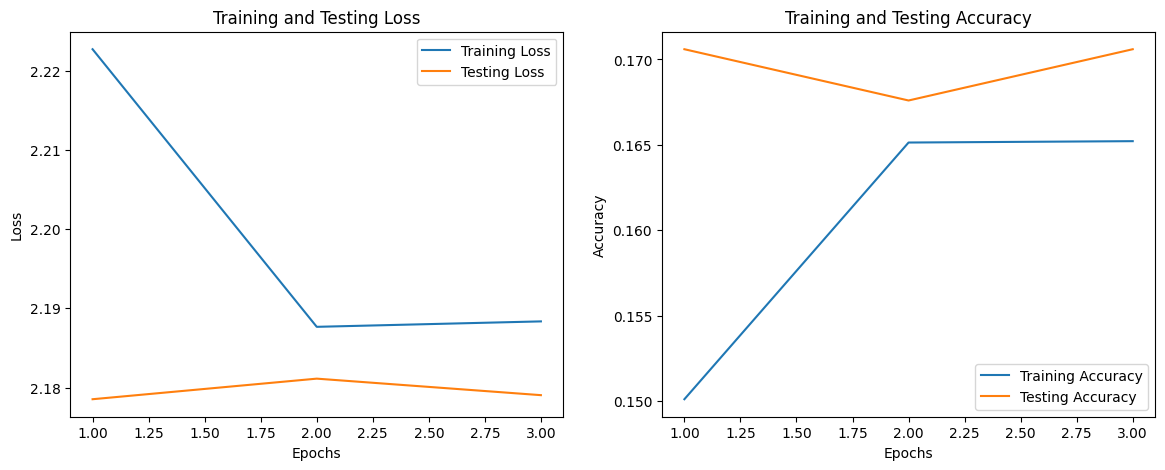

In [86]:
# Set 8:
set8_model = CNN(
    num_filters=[32, 64, 128, 128],
    kernel_size=[(2,2), (2,2), (2,2), (2,2)],
    strides=[(1,1), (1,1), (1,1), (1,1)],
    conv_activation='elu',
    cnn_pool_type= 'max_pool',
    padding='valid',
    use_bias=False,
    dense_activation='softmax',
    dense_sizes=[128],
    flatten_type='global_max',
    name="Set_8",
)
train_data8, test_data8 = tfds.load('cifar10', split=['train', 'test'], as_supervised=True)


batch_size_set8 = 32
train_data_set8, test_data_set8 = prep_cifar(train_data8, test_data8, batch_size_set8)

# Train set 1 model with the specified hyperparameters
set8_model.train(train_data_set8, test_data_set8, epochs=3)

#set1_model.train(train_data_set1, test_data_set1, epochs=15, learning_rate=0.0001, optimizer='rmsprop')
set8_model.visualize_performance()